In [21]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import pydicom
import cv2
import keras

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

In [2]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [3]:
def binary_crossentropy_custom(y_true, y_pred, from_logits=False, label_smoothing=0):
    y_pred = K.constant(y_pred) if not K.is_tensor(y_pred) else y_pred
    y_true = K.cast(y_true, y_pred.dtype)
    if label_smoothing is not 0:
        smoothing = K.cast_to_floatx(label_smoothing)
        y_true = K.switch(K.greater(smoothing, 0),
                          lambda: y_true * (1.0 - smoothing) + 0.5 * smoothing,
                          lambda: y_true)
    return K.mean(
        K.binary_crossentropy(y_true, K.round(y_pred), from_logits=from_logits), axis=-1)

In [9]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan

In [10]:
IMG_HEIGHT, IMG_WIDTH = 64, 64
SEED=42

In [12]:
ct_scan = load_itk("/home/shrey/kurispc11/Documents/Shrey/LUNA/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd")
lung_seg = load_itk("/home/shrey/kurispc11/Documents/Shrey/LUNA/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd")

In [13]:
print(ct_scan.shape, lung_seg.shape)

(121, 512, 512) (121, 512, 512)


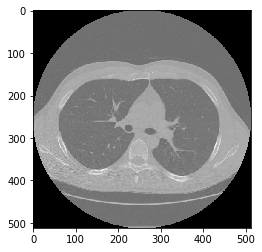

In [14]:
plt.imshow(ct_scan[70], cmap='gray')

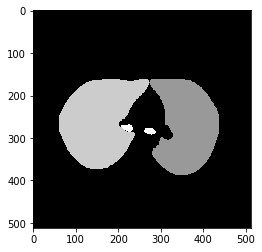

In [15]:
plt.imshow(lung_seg[70].round(), cmap='gray')

In [16]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, y=None, batch_size=batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y=None, batch_size=batch_size, seed=SEED)
    while True:
        x_batch = data_generator.next()
        y_batch = mask_generator.next()
        yield x_batch, y_batch

In [12]:
input_layer = Input(shape=(64,64,1))
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(filters=32, kernel_size=(3,3), strides = (2, 2), padding='same')(c4), c3], axis=-1)
c5 = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(filters=16, kernel_size=(3,3), strides = (2, 2), padding='same')(c5), c2], axis=-1)
c6 = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(filters=8, kernel_size=(3,3), strides = (2, 2), padding='same')(c6), c1], axis=-1)
c7 = Conv2D(filters=8, kernel_size=(2,2), activation='relu', padding='same')(l)
#c8 = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(c7)
l = Dropout(0.5)(c7)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)
model.summary()

W0912 15:48:24.149871 139993662322496 deprecation_wrapper.py:119] From /home/shrey/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 15:48:24.430145 139993662322496 deprecation_wrapper.py:119] From /home/shrey/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 15:48:24.462632 139993662322496 deprecation_wrapper.py:119] From /home/shrey/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0912 15:48:24.493855 139993662322496 deprecation_wrapper.py:119] From /home/shrey/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0912 15:48

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 16)   1168        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [13]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

W0912 15:48:24.708484 139993662322496 deprecation_wrapper.py:119] From /home/shrey/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0912 15:48:24.713101 139993662322496 deprecation_wrapper.py:119] From /home/shrey/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0912 15:48:24.717095 139993662322496 deprecation.py:323] From /home/shrey/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [14]:
i=0
x_data=[]
y_data=[]
for folder in sorted(glob.glob("/home/shrey/kurispc11/Documents/Shrey/LUNA/subset0/*.mhd")):
    if(i%10==0):
        print(i, len(x_data))
    ct_scan = load_itk(folder)
    ls = folder.split("/")
    ls[-2] = "seg-lungs-LUNA16"
    ls = '/'.join(ls)
    lung_seg = load_itk(ls)
    for ct in ct_scan:
        im = cv2.resize(ct, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        x_data.append(im)
        if(len(x_data)>20000): break
    for lu in lung_seg:
        im2 = cv2.resize(lu, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
        if(np.max(im2) != np.min(im2)):
            im2 = (im2 - np.min(im2)) / (np.max(im2) - np.min(im2))
        y_data.append(im2)
        if(len(y_data)>20000): break
    i=i+1

x_data = np.array(x_data)
y_data = np.array(y_data)
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2)

hist = model.fit_generator(my_generator(x_train, y_train, 8),
                       steps_per_epoch = 200,
                       validation_data = (x_val, y_val),
                       epochs=20, verbose=1, shuffle=True,
                       callbacks = [annealer, es])

model.save_weights('/home/shrey/kurispc11/Documents/Shrey/LUNA/Saved_Models/lung_{}.h5'.format(folder.split("/")[-2]))

0 0
10 2679
20 5861
30 7835
40 10350
50 13126
60 15436
70 17958
80 20004
Epoch 1/20
200/200 [==============================] - 17s 87ms/step - loss: 0.5514 - dice_coef: 0.2454 - val_loss: 0.4527 - val_dice_coef: 0.2505
Epoch 2/20
200/200 [==============================] - 14s 70ms/step - loss: 0.4622 - dice_coef: 0.3067 - val_loss: 0.4113 - val_dice_coef: 0.3451
Epoch 3/20
200/200 [==============================] - 14s 69ms/step - loss: 0.4490 - dice_coef: 0.3385 - val_loss: 0.4019 - val_dice_coef: 0.3637
Epoch 4/20
200/200 [==============================] - 14s 69ms/step - loss: 0.4389 - dice_coef: 0.3487 - val_loss: 0.3996 - val_dice_coef: 0.3603
Epoch 5/20
200/200 [==============================] - 14s 70ms/step - loss: 0.4288 - dice_coef: 0.3449 - val_loss: 0.3970 - val_dice_coef: 0.3526
Epoch 6/20
200/200 [==============================] - 14s 69ms/step - loss: 0.4201 - dice_coef: 0.3431 - val_loss: 0.3944 - val_dice_coef: 0.3717
Epoch 7/20
200/200 [==============================]

In [23]:
#RUN THIS CODE SEVERAL TIMES FOR TRAINING FURTHER SUBSETS 
num=0
for main in sorted(glob.glob("/home/shrey/kurispc11/Documents/Shrey/LUNA/Saved_Models/*")):
    file = main
model.load_weights(file)
num = int(file[-4])
num+=1
main = "/home/shrey/kurispc11/Documents/Shrey/LUNA/subset"+str(num)
print(main)
i=0
x_data=[]
y_data=[]
for folder in sorted(glob.glob(main+"/*.mhd")):
    if(i%10==0):
        print(i, len(x_data))
    ct_scan = load_itk(folder)
    ls = folder.split("/")
    ls[-2] = "seg-lungs-LUNA16"
    ls = '/'.join(ls)
    lung_seg = load_itk(ls)
    
    for ct in ct_scan:
        if(len(x_data)>20000): break
        im = cv2.resize(ct, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        x_data.append(im)
        
    for lu in lung_seg:
        if(len(y_data)>20000): break
        im2 = cv2.resize(lu, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
        if(np.max(im2) != np.min(im2)):
            im2 = (im2 - np.min(im2)) / (np.max(im2) - np.min(im2))
        y_data.append(im2)
        
    i=i+1

x_data = np.array(x_data)
y_data = np.array(y_data)
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2)

hist = model.fit_generator(my_generator(x_train, y_train, 8),
                       steps_per_epoch = 200,
                       validation_data = (x_val, y_val),
                       epochs=20, verbose=1, shuffle=True,
                       callbacks = [annealer, es])

model.save_weights('/home/shrey/kurispc11/Documents/Shrey/LUNA/Saved_Models/lung_{}.h5'.format(folder.split("/")[-2]))

/home/shrey/Documents/Shrey/LUNA/subset6
0 0
10 2222
20 4902
30 7511
40 9679
50 12300
60 15345
70 17784
80 20001
Epoch 1/20
200/200 [==============================] - 14s 72ms/step - loss: 0.4000 - dice_coef: 0.3643 - val_loss: 0.3672 - val_dice_coef: 0.3869
Epoch 2/20
200/200 [==============================] - 14s 72ms/step - loss: 0.3943 - dice_coef: 0.3717 - val_loss: 0.3662 - val_dice_coef: 0.3805
Epoch 3/20
200/200 [==============================] - 15s 73ms/step - loss: 0.3963 - dice_coef: 0.3699 - val_loss: 0.3673 - val_dice_coef: 0.3810
Epoch 4/20
200/200 [==============================] - 14s 72ms/step - loss: 0.3947 - dice_coef: 0.3652 - val_loss: 0.3708 - val_dice_coef: 0.3654
Epoch 5/20
200/200 [==============================] - 15s 73ms/step - loss: 0.3948 - dice_coef: 0.3671 - val_loss: 0.3666 - val_dice_coef: 0.3784
Epoch 00005: early stopping


In [26]:
model.save('/home/shrey/kurispc11/Documents/Shrey/LUNA/Saved_Models/lung.h5')

In [6]:
model = load_model('/home/shrey/kurispc11/Documents/Shrey/LUNA/Saved_Models/lung.h5', custom_objects={'dice_coef': dice_coef})

In [65]:
i=0
x_data=[]
y_data=[]
for folder in sorted(glob.glob("/home/shrey/kurispc11/Documents/Shrey/LUNA/subset9/*.mhd")):
    if(i%10==0):
        print(i, len(x_data))
    ct_scan = load_itk(folder)
    ls = folder.split("/")
    ls[-2] = "seg-lungs-LUNA16"
    ls = '/'.join(ls)
    lung_seg = load_itk(ls)
    for ct in ct_scan:
        im = cv2.resize(ct, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        x_data.append(im)
    for lu in lung_seg:
        im2 = cv2.resize(lu, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
        if(np.max(im2) != np.min(im2)):
            im2 = (im2 - np.min(im2)) / (np.max(im2) - np.min(im2))
        y_data.append(im2)
    i=i+1

x_test = np.array(x_data)
y_test = np.array(y_data)
x_test = x_test[:,:,:,np.newaxis]
y_test = y_test[:,:,:,np.newaxis]

0 0
10 2699
20 5498
30 8331
40 11172
50 13930
60 16762
70 18970
80 21002


/home/shrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in short_scalars
  


In [66]:
#y_test[y_test>0]=1

In [67]:
y_hat = model.predict(x_test)

In [68]:
auc = roc_auc_score(y_test.round().ravel(), y_hat.ravel())
print("AUC:",auc)

AUC: 0.9972679259671106


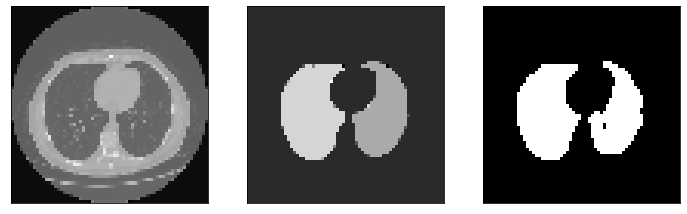

In [69]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[0].imshow(x_test[60,:,:,0], cmap='gray')
ax[1].imshow(y_test[60,:,:,0], cmap='gray')
ax[2].imshow(np.round(y_hat[60,:,:,0]), cmap='gray')